In [27]:
#https://github.com/zclaytor/kiauhoku/blob/master/notebooks/mcmc_offsets.ipynb
import numpy as np
import matplotlib.pyplot as plt
import kiauhoku as kh

In [28]:
# data/err are [teff, L/Lsun, [M/H]]
#data = [3327, 0.0967, -0.12] #au mic post star lite
#err = [32, 0.0022, 0.11] #au mic post star lite
data = [4864, 0.4375, -0.02] #HD3167 post star lite
err = [18, 0.01, 0.17] #HD3167 post star lite


In [29]:
yrec = kh.load_interpolator('yrec')
mist = kh.load_interpolator('mist')
dart = kh.load_interpolator('dartmouth')
gars = kh.load_interpolator('garstec')

In [30]:
def yrec_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None

    model_teff = 10**model['Log Teff(K)']
    model_lum = 10**model['L/Lsun']
    model_met = np.log10(model['Zsurf']/model['Xsurf']/0.0253)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age(Gyr)']
    model['lnprob'] = chisq
    
    return chisq, model

def mist_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = 10**model['log_Teff']
    model_lum = 10**model['log_L']
    model_met = model['log_surf_z'] - np.log10(model['surface_h1']*0.0173)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['star_age'] / 1e9
    model['lnprob'] = chisq

    return chisq, model

def dart_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = 10**model['Log T']
    model_lum = 10**model['Log L']
    model_met = np.log10(model['(Z/X)_surf']/0.0229)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age (yrs)'] / 1e9
    model['lnprob'] = chisq

    return chisq, model

def gars_prob(theta, grid, data, error):
    model = grid.get_star_eep(theta)
    if model.isnull().any():
        return -np.inf, None
    
    model_teff = model['Teff']
    model_lum = 10**model['Log L/Lsun']
    model_met = np.log10(model['Zsurf']/model['Xsurf']/0.0245)

    model_params = np.array([model_teff, model_lum, model_met])
    data = np.array(data)
    error = np.array(error)

    chisq = -0.5 * np.sum(((model_params - data)/error)**2)

    model['teff'] = model_teff
    model['luminosity'] = model_lum
    model['metallicity'] = model_met
    model['age'] = model['Age(Myr)'] / 1e3
    model['lnprob'] = chisq

    return chisq, model


In [31]:


def mcmc(grid, lnprob, data, err):
    sampler, chains = grid.mcmc_star(
        lnprob,
        args=(data, err),
        initial_guess=(0.7, 0, 100),
        guess_width=(0.1, 0.1, 100),
        n_walkers=12,
        n_burnin=100,
        n_iter=1000
    )
    
    return sampler, chains

def compute_offsets(label, ref='yrec'):
    if ref == 'yrec':
        ref_val = yrec_chains[label].median()
    elif ref == 'mist':
        ref_val = mist_chains[label].median()
    elif ref == 'dart':
        ref_val = dart_chains[label].median()
    elif ref == 'gars':
        ref_val = gars_chains[label].median()

    offsets = {
        f'yrec-{ref}': yrec_chains[label].median() - ref_val,
        f'mist-{ref}': mist_chains[label].median() - ref_val,
        f'dart-{ref}': dart_chains[label].median() - ref_val,
        f'gars-{ref}': gars_chains[label].median() - ref_val
    }

    offsets.pop(f'{ref}-{ref}')
    return offsets



In [32]:
yrec_sampler, yrec_chains = mcmc(yrec, yrec_prob, data, err)
mist_sampler, mist_chains = mcmc(mist, mist_prob, data, err)
dart_sampler, dart_chains = mcmc(dart, dart_prob, data, err)
gars_sampler, gars_chains = mcmc(gars, gars_prob, data, err)


  0%|                                                                                               | 0/100 [00:00<?, ?it/s]/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: R

/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 21%|██████████████████                                                                    | 21/100 [00:00<00:01, 74.75it/s]/home/jtayar/miniconda3/envs/kiauhoku2/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: R

In [33]:
print(compute_offsets('age'))
print(compute_offsets('initial_mass'))

{'mist-yrec': 0.0031200447674861534, 'dart-yrec': 9.241340843994783, 'gars-yrec': 0.000620997979618669}
{'mist-yrec': -0.042889440446983396, 'dart-yrec': -0.08582454972020526, 'gars-yrec': -0.0036159596019350593}


In [34]:
from corner import corner
#pip install corner

In [46]:
#agelimit=2 #AU MIC
agelimit=14 #hd3167

In [47]:
print(yrec_chains)
yrec_chains_young=yrec_chains.drop(yrec_chains[yrec_chains.age>agelimit].index)

       initial_mass  initial_met         eep   Age(Gyr)    L/Lsun    R/Rsun  \
0          0.914501    -0.028068  134.646314   0.024785 -0.358499 -0.024723   
1          0.907541     0.040644  142.716359   0.027543 -0.368832 -0.034345   
2          0.928567     0.188049  146.332066   0.028549 -0.363752 -0.032087   
3          0.938085     0.289606  152.264123   0.030273 -0.358039 -0.033635   
4          0.814835     0.372600  381.177790  18.227685 -0.406164 -0.081876   
...             ...          ...         ...        ...       ...       ...   
11995      0.855212    -0.429924  118.126234   0.018416 -0.348952 -0.026100   
11996      0.868188    -0.374806  119.024342   0.018735 -0.345568 -0.022590   
11997      0.884054    -0.180645  131.444386   0.023301 -0.361174 -0.030872   
11998      0.906577    -0.005188  141.133358   0.026815 -0.360747 -0.032005   
11999      0.882808    -0.123381  136.859779   0.025429 -0.371280 -0.036836   

           logg  Log Teff(K)  mass_conv_core  mass_

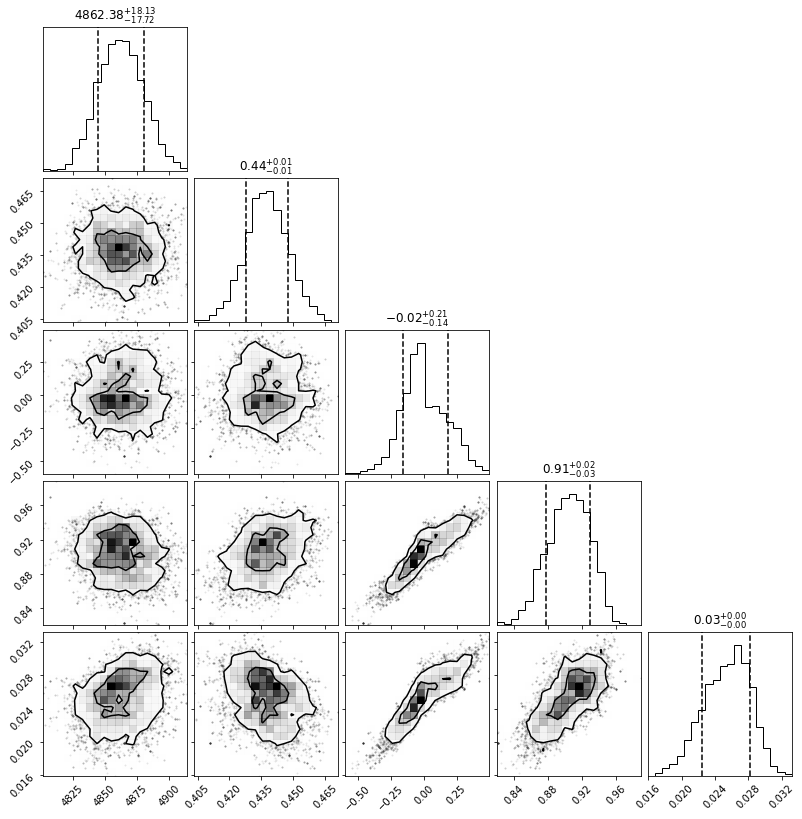

In [48]:
fig = corner(yrec_chains_young[['teff', 'luminosity', 'metallicity', 'Mass(Msun)', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('yrec_corner_poststarlite.png')

In [49]:
print (mist_chains)
mist_chains_young=mist_chains.drop(mist_chains[mist_chains.age>agelimit].index)

       initial_mass  initial_met         eep      star_age  star_mass  \
0          0.610928    -0.161979  442.945082  4.920463e+10   0.610541   
1          0.842641    -0.355873  183.059130  1.982647e+07   0.842639   
2          0.886829    -0.154462  183.530250  2.177791e+07   0.886828   
3          0.818515     0.369518  409.273761  1.838240e+10   0.818294   
4          0.690392    -0.040787  422.497800  3.084306e+10   0.690100   
...             ...          ...         ...           ...        ...   
11995      0.832064    -0.450293  181.950709  1.758273e+07   0.832063   
11996      0.814786     0.478088  422.469108  2.223803e+10   0.814529   
11997      0.885898    -0.012639  186.359552  2.737588e+07   0.885896   
11998      0.889592     0.098437  187.685759  3.100354e+07   0.889591   
11999      0.784372     0.440773  428.624849  2.647774e+10   0.784088   

          star_mdot  he_core_mass  c_core_mass  o_core_mass     log_L  ...  \
0     -2.681656e-14      0.004233          0.

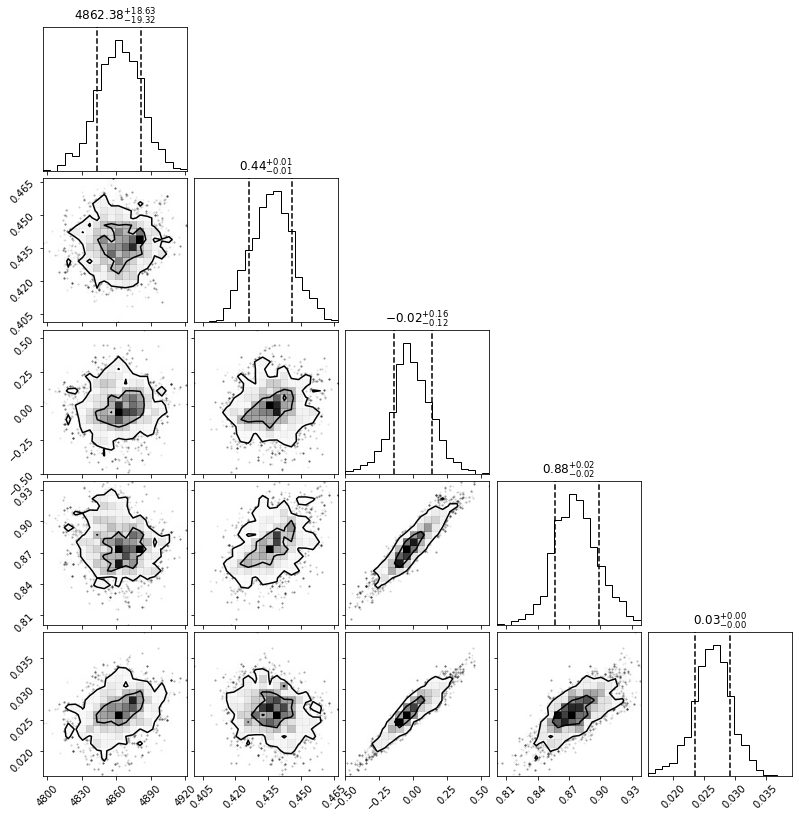

In [50]:
fig = corner(mist_chains_young[['teff', 'luminosity', 'metallicity', 'star_mass', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('mist_corner_poststarlite.png')

In [51]:
print(dart_chains)
dart_chains_young=dart_chains.drop(dart_chains[dart_chains.age>agelimit].index)

       initial_mass  initial_met         eep     Age (yrs)     Log T  \
0          0.840547    -0.311744  143.484405  2.435382e+07  3.689993   
1          0.870359    -0.080267  152.714216  2.998152e+07  3.686116   
2          0.726881     0.163315  438.573161  3.076216e+10  3.686964   
3          0.775772     0.320588  426.215054  2.338378e+10  3.690465   
4          0.733883     0.168988  434.939164  2.924539e+10  3.688055   
...             ...          ...         ...           ...       ...   
11995      0.921804     0.124364  152.823837  2.961338e+07  3.687317   
11996      0.887061    -0.153287  143.805191  2.510744e+07  3.686874   
11997      0.871020    -0.230097  141.242307  2.386100e+07  3.686795   
11998      0.700967     0.059285  447.592264  3.528837e+10  3.687036   
11999      0.792612     0.440587  423.267265  2.128600e+10  3.688011   

          Log g     Log L     Log R    Y_core    Z_core  ...       L_H  L_He  \
0      4.447736 -0.371973 -0.042716  0.261369  0.010449

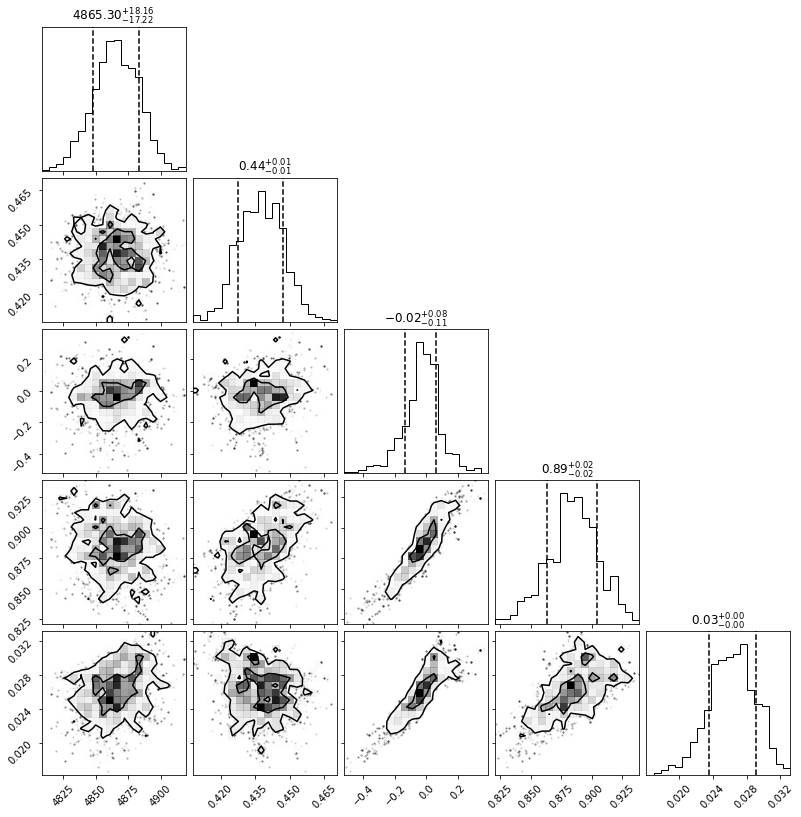

In [52]:
fig = corner(dart_chains_young[['teff', 'luminosity', 'metallicity', 'initial_mass',  'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)))
fig.savefig('dart_corner_poststarlite.png')

In [53]:
gars_chains_nonan=(gars_chains.dropna())
#t=[np.NaN,np.NaN, np.NaN, 1]

gars_chains_nonanyoung=gars_chains_nonan.drop(gars_chains_nonan[gars_chains_nonan.age>agelimit].index)

In [54]:
print(gars_chains_nonanyoung)

       initial_mass  initial_met        eep   Age(Myr)    M/Msun         Teff  \
0          0.951984     0.199344  47.832418  26.614330  0.951984  4834.506097   
1          0.916471     0.020897  45.158943  27.170451  0.916471  4853.160715   
2          0.904981    -0.007395  48.156433  27.712921  0.904981  4854.000659   
3          0.916969    -0.080374  10.218167  23.656443  0.916969  4839.253333   
4          0.918857     0.167590  78.749541  30.456553  0.918857  4878.071902   
...             ...          ...        ...        ...       ...          ...   
11993      0.885094    -0.155682  31.467189  25.298926  0.885094  4902.839695   
11994      0.919191     0.043353  49.353468  27.444894  0.919191  4860.834873   
11997      0.885656    -0.124776  37.016666  26.113570  0.885656  4886.550192   
11998      0.901749    -0.082595  29.769376  25.509583  0.901749  4867.962969   
11999      0.901318    -0.040419  48.212982  27.368034  0.901318  4884.759236   

       Log L/Lsun    R/Rsun

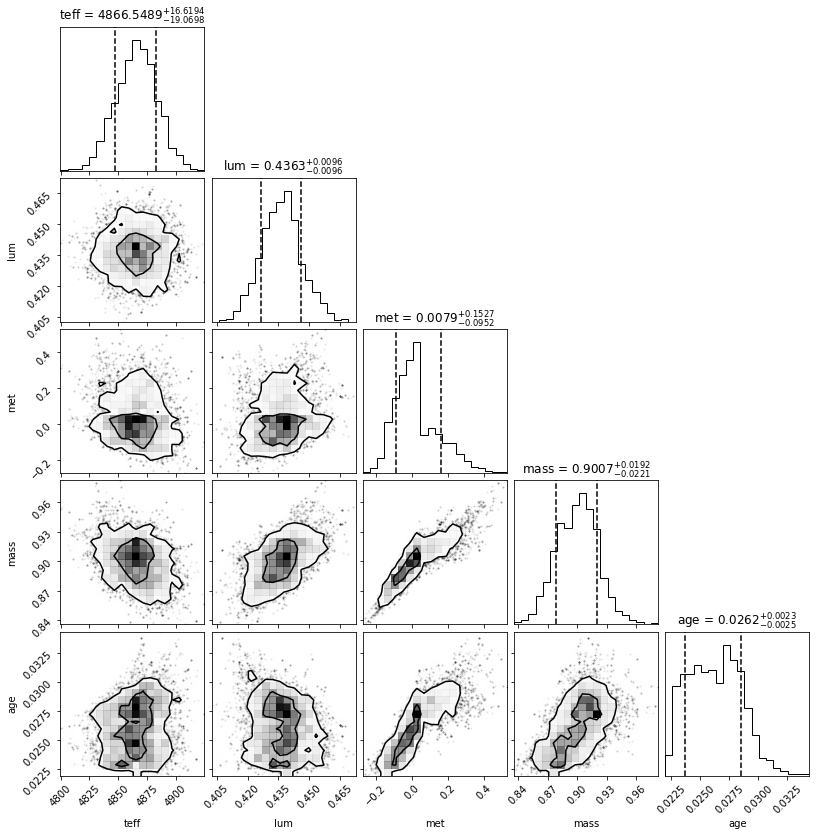

In [55]:

fig = corner(gars_chains_nonanyoung[['teff', 'luminosity', 'metallicity', 'M/Msun', 'age']], 
    show_titles=True, quantiles=(0.16, 0.84), levels=(1-np.exp(-2), 1-np.exp(-0.5)), title_fmt='.4f',
             labels=['teff', 'lum', 'met', 'mass', 'age' ])
#axes = np.array(fig.axes).reshape((5, 5))
#ax = axes[0, 3]
#ax.set_xlim([0,1])
fig.savefig('gars_corner_poststarlite.png')


In [56]:
#from corner import quantile

In [57]:
#print(quantile(gars_chains_nonan[['teff', 'luminosity', 'metallicity', 'M/Msun', 'age']]))